## Persistence Landscapes

- vectorized representations of persistence diagrams

- per homology group rank (ex H0, H1, or H2)
- per stimuli
- per region
- difference landscapes

Author: @emilyekstrum
<br> 11/17/25

In [2]:
import pickle as pkl
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from persim import PersLandscapeApprox
from persim import persistent_entropy
from persim.landscapes import average_approx
from persim.landscapes import snap_pl
from persim.landscapes import plot_landscape_simple
from persim.landscapes import plot_landscape
import random
import os
from matplotlib.lines import Line2D
import numpy as np
from typing import Optional, Tuple, Sequence, Any
from sklearn.decomposition import PCA
from ripser import ripser
from persim import wasserstein
from sklearn.neighbors import NearestNeighbors    
from scipy.sparse import coo_matrix    


# for plots
- x axis = filtration parameter (midpoint of feature (death - birth)/2)
- y axis = "feature persistence strength" (half-life of feature (birth+death)/2)

In [3]:
data_dir = os.path.join("C:\\Users\\denmanlab\\Desktop\\Emily_rotation\\Ripser\\CEBRA_H2")  # path to dgms pickle files

stim_map = {
    "dg": "drifting_gratings",
    "cg": "chromatic_gratings",
    "ce": "color_exchange",
    "lf": "luminance_flash",
}

def parse_filename(fname: str):
    """ Parse filename to get method, embed_dim, region, stim, mouse 
    ** important: expects filename structure: method_embedDim_region_stim_mouse.pkl **
    
    Args:
        fname (str): filename
    Returns:
        dict: method, embed_dim, region, stim, mouse"""

    base = os.path.basename(fname)
    name, _ = os.path.splitext(base)
    parts = name.split("_")

    if len(parts) < 5:
        raise ValueError(f"Unexpected filename structure: {fname}")

    method = parts[0]
    embed_dim = parts[1]   
    region = parts[2]      
    stim_code = parts[3]   
    mouse = parts[4]      

    stim = stim_map.get(stim_code, stim_code)

    return {
        "method": method,
        "embed_dim": embed_dim,
        "region": region,
        "stim": stim,
        "mouse": mouse,
    }

def load_dgms(path: str):
    """ Load diagrams from pickle file
    
    Args:
        path (str): path to pickle file
    Returns:
        list: diagrams"""

    with open(path, "rb") as f:
        dgms = pkl.load(f)
    return dgms

## By region

In [4]:
# average landscapes for each homology group (H0, H1, H2)
avg_lgn_landscapes = {}
avg_v1_landscapes = {}

LGN_files = [f for f in os.listdir(data_dir) if f.endswith(".pkl") and "LGN" in f]
V1_files = [f for f in os.listdir(data_dir) if f.endswith(".pkl") and "V1" in f]

for hom_deg in range(3): 
    LGN_landscape = []
    V1_landscape = []
    
    for f in LGN_files:
        try:
            fpath = os.path.join(data_dir, f)
            dgms = load_dgms(fpath)
            if isinstance(dgms, np.ndarray):
                dgms = dgms.tolist()
            if dgms and len(dgms) > hom_deg:
                if dgms[hom_deg] is not None and len(dgms[hom_deg]) > 0:
                    persistence_landscape = PersLandscapeApprox(dgms=dgms, hom_deg=hom_deg)
                    LGN_landscape.append(persistence_landscape)
        except Exception as e:
            continue
    
    for f in V1_files:
        try:
            fpath = os.path.join(data_dir, f)
            dgms = load_dgms(fpath)
            if isinstance(dgms, np.ndarray):
                dgms = dgms.tolist()
            if dgms and len(dgms) > hom_deg:
                if dgms[hom_deg] is not None and len(dgms[hom_deg]) > 0:
                    persistence_landscape = PersLandscapeApprox(dgms=dgms, hom_deg=hom_deg)
                    V1_landscape.append(persistence_landscape)
        except Exception as e:
            continue
    
    # Average persistence landscapes 
    if LGN_landscape:
        avg_lgn_landscapes[f'H{hom_deg}'] = average_approx(LGN_landscape)
    if V1_landscape:
        avg_v1_landscapes[f'H{hom_deg}'] = average_approx(V1_landscape)

avg_lgn_h0_landscape = avg_lgn_landscapes.get('H0')
avg_lgn_h1_landscape = avg_lgn_landscapes.get('H1')
avg_lgn_h2_landscape = avg_lgn_landscapes.get('H2')
avg_v1_h0_landscape = avg_v1_landscapes.get('H0')
avg_v1_h1_landscape = avg_v1_landscapes.get('H1')
avg_v1_h2_landscape = avg_v1_landscapes.get('H2')


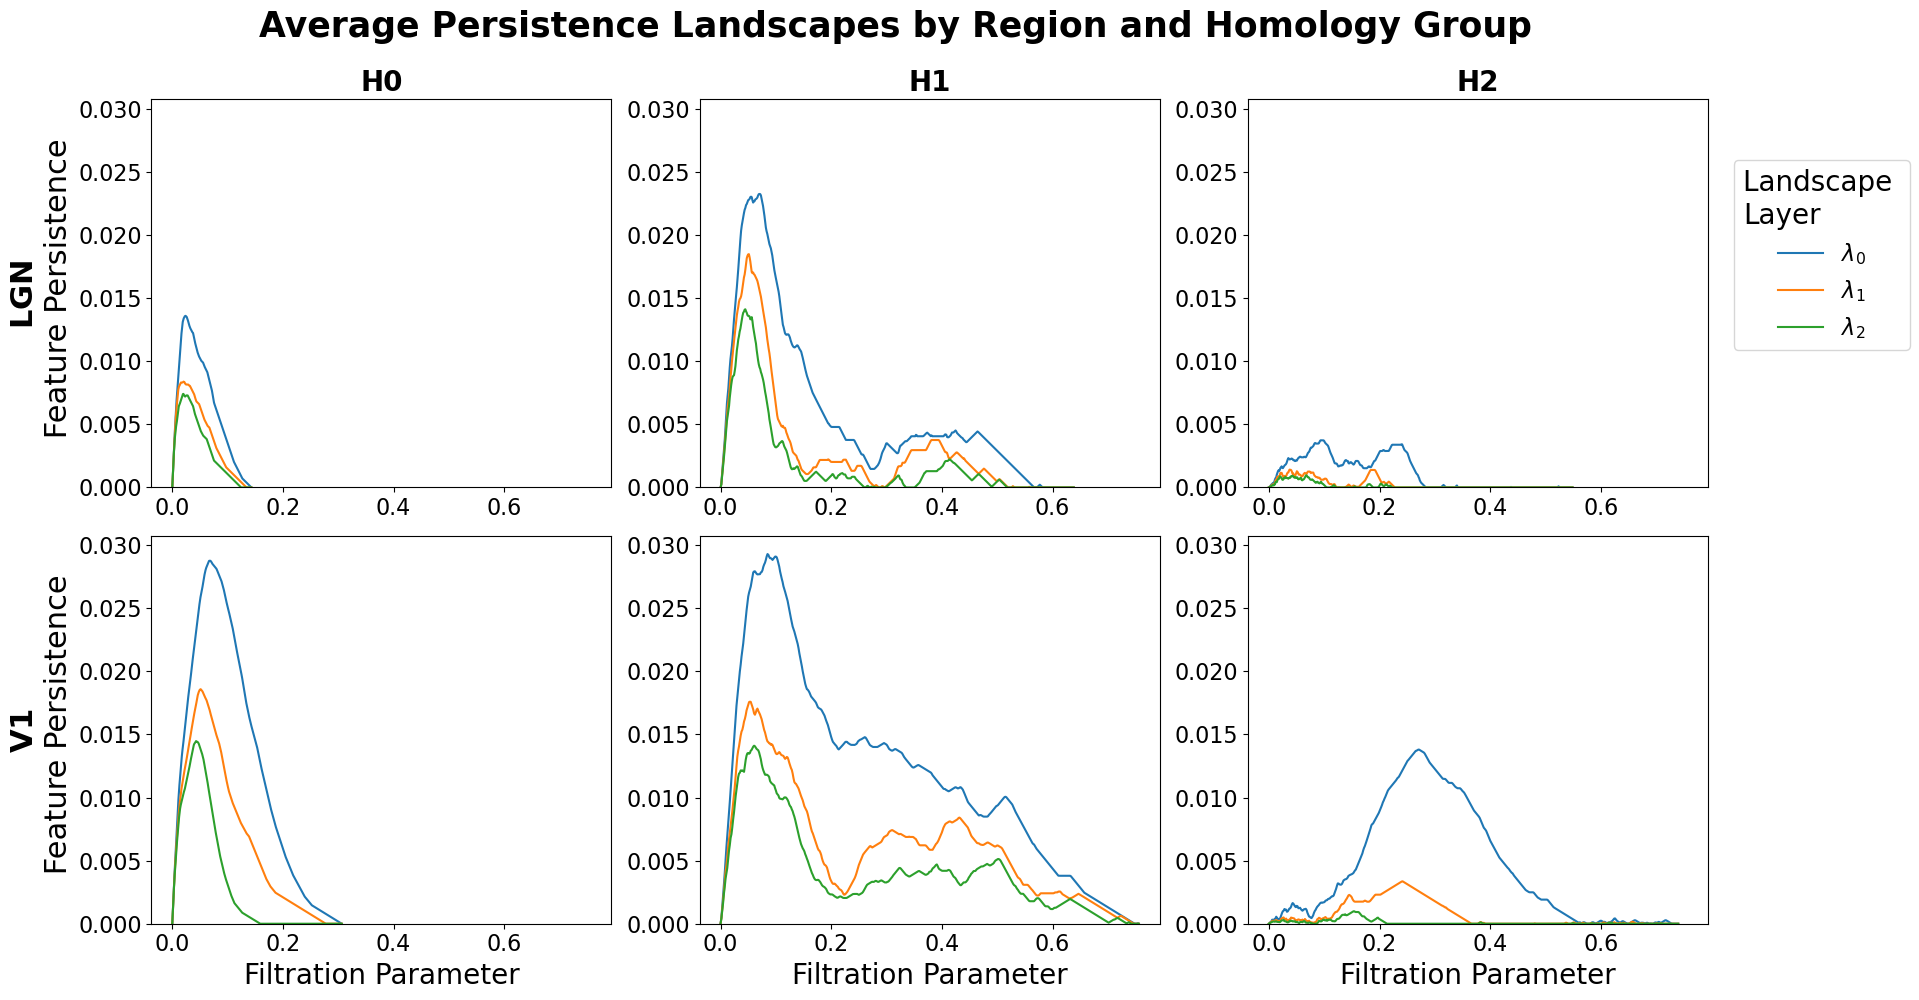

In [5]:
# plot average persistence landscapes for V1 and LGN for each homology group

fig, axes = plt.subplots(2, 3, figsize=(18, 10))

# landscapes and labels
landscapes = {
    'LGN': {
        'H0': avg_lgn_h0_landscape,
        'H1': avg_lgn_h1_landscape,
        'H2': avg_lgn_h2_landscape
    },
    'V1': {
        'H0': avg_v1_h0_landscape,
        'H1': avg_v1_h1_landscape,
        'H2': avg_v1_h2_landscape
    }
}

homology_groups = ['H0', 'H1', 'H2']
regions = ['LGN', 'V1']

def count_valid_diagrams(file_list, hom_deg):
    """ Count diagrams in a list of files

    Args:
        file_list (list): list of file names
        hom_deg (int): homology group degree

    Returns:
        int: number of valid diagrams"""

    count = 0
    for fname in file_list:
        try:
            fpath = os.path.join(data_dir, fname)
            dgms = load_dgms(fpath)
            if isinstance(dgms, np.ndarray):
                dgms = dgms.tolist()
            if dgms and len(dgms) > hom_deg:
                dgm = dgms[hom_deg]
                if dgm is not None and len(dgm) > 0:
                    count += 1
        except Exception:
            continue
    return count

diagram_counts = {
    'LGN': {group: count_valid_diagrams(LGN_files, int(group[1])) for group in homology_groups},
    'V1': {group: count_valid_diagrams(V1_files, int(group[1])) for group in homology_groups}
}

# calculate global x and y limits across all landscapes
all_x_values = []
all_y_values = []

for region in regions:
    for group in homology_groups:
        landscape = landscapes[region][group]
        try:
            xs = landscape.grid
        except AttributeError:
            try:
                xs = landscape.xs
            except AttributeError:
                xs = np.linspace(landscape.start, landscape.stop, landscape.num_steps)
        
        try:
            landscapes_data = landscape.landscapes
        except AttributeError:
            try:
                landscapes_data = landscape.values
            except AttributeError:
                landscapes_data = landscape.Ls
        
        all_x_values.extend(xs)
        # Get y values from first 10 lambda function
        n_layers = min(10, len(landscapes_data))
        for i in range(n_layers):
            all_y_values.extend(landscapes_data[i])

# Calculate global limits
x_min = min(all_x_values)
x_max = max(all_x_values)
y_min = min(all_y_values)
y_max = max(all_y_values)

# Add small padding
x_padding = (x_max - x_min) * 0.05
y_padding = (y_max - y_min) * 0.05
x_min -= x_padding
x_max += x_padding
y_min = max(0, y_min - y_padding)  # Don't go below 0 for y
y_max += y_padding

# Plot landscapes using plot_landscape_simple()
for row_idx, region in enumerate(regions):
    for col_idx, group in enumerate(homology_groups):
        ax = axes[row_idx, col_idx]
        landscape = landscapes[region][group]
        
        # Set current axes and plot using plot_landscape_simple()
        plt.sca(ax)
        plot_landscape_simple(landscape, title="", depth_range=range(3))
        
        # Remove legend from individual subplot
        ax.legend().remove()
        
        # Set the same axis limits for all subplots
        ax.set_xlim(x_min, x_max)
        ax.set_ylim(y_min, y_max)
        ax.tick_params(axis='x', labelsize=16) 
        ax.tick_params(axis='y', labelsize=16)

        # Set labels
        if row_idx == 0:
            ax.set_title(
                f"{homology_groups[col_idx]}",
                fontsize=20,
                fontweight='bold'
            )
        if col_idx == 0:
            ax.set_ylabel(f"$\\bf{{{region}}}$ \n Feature Persistence", fontsize=22)
        
        # Set axis labels for bottom row
        if row_idx == 1:
            ax.set_xlabel("Filtration Parameter", fontsize=20)
            


handles, labels = axes[0, 0].get_legend_handles_labels()
if len(handles) == 0:
    handles = [Line2D([0], [0], color=plt.cm.viridis(i/9), linewidth=1.5) for i in range(3)]
    labels = [f'λ{i}' for i in range(3)]

#fig.text(0.955, 0.9, f"n={diagram_counts['LGN']['H0']}", transform=fig.transFigure, fontsize=16, ha='left', va='top', bbox=dict(facecolor='white', alpha=0, edgecolor='none'))
#fig.text(0.955, 0.46, f"n={diagram_counts['V1']['H0']}", transform=fig.transFigure, fontsize=16, ha='left', va='top', bbox=dict(facecolor='white', alpha=0, edgecolor='none'))
fig.legend(handles, labels, loc='center right', bbox_to_anchor=(1.07, 0.75), title='Landscape \nLayer', fontsize=16, title_fontsize=20)

fig.suptitle('Average Persistence Landscapes by Region and Homology Group', fontsize=25, fontweight='bold', y=0.995)

plt.tight_layout(rect=[0, 0, 0.96, 1]) 
plt.show()


In [12]:

# snap landscapes to a common grid
[avg_lgn_h2_snapped, avg_v1_h2_snapped] = snap_pl([avg_lgn_h2_landscape, avg_v1_h2_landscape])

true_diff_pl = avg_v1_h2_snapped - avg_lgn_h2_snapped
significance = true_diff_pl.sup_norm()

print(f"Significance: {significance}")


Significance: 0.013103947419908675


<Axes: title={'center': 'Difference Landscape - H2'}>

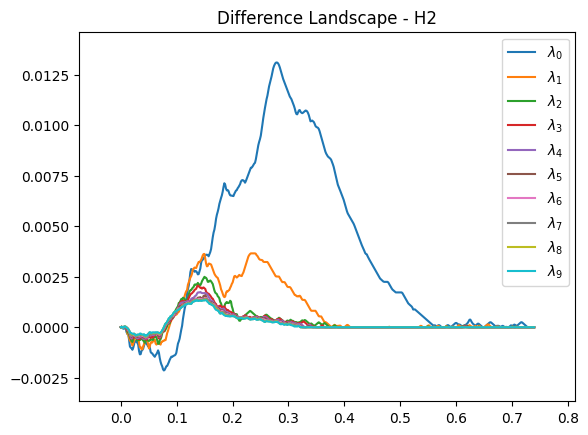

In [13]:
# plot difference landscape 
plot_landscape_simple(true_diff_pl, title = "Difference Landscape - H2", depth_range=range(10))


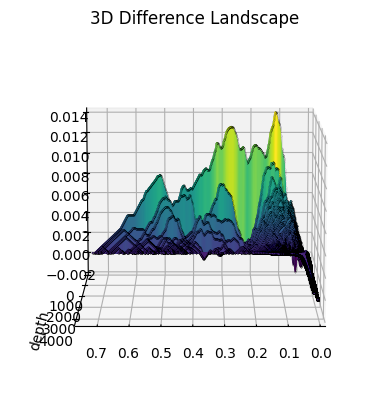

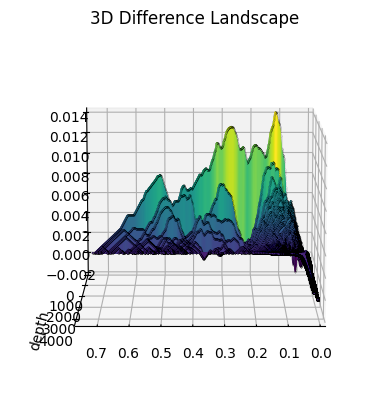

In [ ]:
# plot 3d difference landscape
plot_landscape(true_diff_pl, title = "3D Difference Landscape")

In [ ]:
# permutation test - from persim tutorial

num_pts = 1000
num_runs = 10
num_perms = 1000

comb_pl = LGN_landscape + V1_landscape
sig_count = 0

for shuffle in range(num_perms):
    A_indices = random.sample(range(2*num_runs),num_runs)
    B_indices = [_ for _ in range(2*num_runs) if _ not in A_indices]

    A_pl = [comb_pl[i] for i in A_indices]
    B_pl = [comb_pl[j] for j in B_indices]

    A_avg = average_approx(A_pl)
    B_avg = average_approx(B_pl)
    [A_avg_sn, B_avg_sn] = snap_pl([A_avg,B_avg])

    shuff_diff = A_avg_sn - B_avg_sn
    if (shuff_diff.sup_norm() >= significance): sig_count += 1

pval = sig_count/num_perms

print(f'There were {sig_count} shuffles out of {num_perms} that',
     'were more significant than the true labelling. Thus, the',
     f'p-value is {pval}.')

There were 546 shuffles out of 1000 that were more significant than the true labelling. Thus, the p-value is 0.546.


## By Stimulus

In [ ]:
hom_deg = 1 # switch for homology group rank
dim = "d"

lgn_cex_files = [f for f in os.listdir(data_dir) if f.endswith(".pkl") and "cex" in f and "LGN" in f and dim in f]
lgn_lf_files = [f for f in os.listdir(data_dir) if f.endswith(".pkl") and "lf" in f and "LGN" in f and dim in f]
lgn_dg_files = [f for f in os.listdir(data_dir) if f.endswith(".pkl") and "dg" in f and "LGN" in f and dim in f]
lgn_cg_files = [f for f in os.listdir(data_dir) if f.endswith(".pkl") and "cg" in f and "LGN" in f and dim in f]

v1_cex_files = [f for f in os.listdir(data_dir) if f.endswith(".pkl") and "cex" in f and "V1" in f and dim in f]
v1_lf_files = [f for f in os.listdir(data_dir) if f.endswith(".pkl") and "lf" in f and "V1" in f and dim in f]
v1_dg_files = [f for f in os.listdir(data_dir) if f.endswith(".pkl") and "dg" in f and "V1" in f and dim in f]
v1_cg_files = [f for f in os.listdir(data_dir) if f.endswith(".pkl") and "cg" in f and "V1" in f and dim in f]


lgn_CEX_landscape, lgn_LF_landscape, lgn_DG_landscape, lgn_CG_landscape = [], [], [], []
v1_CEX_landscape, v1_LF_landscape, v1_DG_landscape, v1_CG_landscape = [], [], [], []

for f in lgn_cex_files:
        # load diagrams
        fpath = os.path.join(data_dir, f)
        dgms = load_dgms(fpath)
        
        if isinstance(dgms, np.ndarray):
            dgms = dgms.tolist()
        
        if dgms and len(dgms) > 1:
            persistence_landscape = PersLandscapeApprox(dgms=dgms, hom_deg=hom_deg)
            lgn_CEX_landscape.append(persistence_landscape)

for f in v1_cex_files:
        # load diagrams
        fpath = os.path.join(data_dir, f)
        dgms = load_dgms(fpath)
        
        if isinstance(dgms, np.ndarray):
            dgms = dgms.tolist()
        
        if dgms and len(dgms) > 1:
            persistence_landscape = PersLandscapeApprox(dgms=dgms, hom_deg=hom_deg)
            v1_CEX_landscape.append(persistence_landscape)


for f in lgn_lf_files:
        # load diagrams
        fpath = os.path.join(data_dir, f)
        dgms = load_dgms(fpath)
        
        if isinstance(dgms, np.ndarray):
            dgms = dgms.tolist()
        
        if dgms and len(dgms) > 1:
            persistence_landscape = PersLandscapeApprox(dgms=dgms, hom_deg=hom_deg)
            lgn_LF_landscape.append(persistence_landscape)

for f in v1_lf_files:
        # load diagrams
        fpath = os.path.join(data_dir, f)
        dgms = load_dgms(fpath)
        
        if isinstance(dgms, np.ndarray):
            dgms = dgms.tolist()
        
        if dgms and len(dgms) > 1:
            persistence_landscape = PersLandscapeApprox(dgms=dgms, hom_deg=hom_deg)
            v1_LF_landscape.append(persistence_landscape)

for f in lgn_dg_files:
        # load diagrams
        fpath = os.path.join(data_dir, f)
        dgms = load_dgms(fpath)
        
        if isinstance(dgms, np.ndarray):
            dgms = dgms.tolist()
        
        if dgms and len(dgms) > 1:
            persistence_landscape = PersLandscapeApprox(dgms=dgms, hom_deg=hom_deg)
            lgn_DG_landscape.append(persistence_landscape)

for f in v1_dg_files:
        # load diagrams
        fpath = os.path.join(data_dir, f)
        dgms = load_dgms(fpath)
        
        if isinstance(dgms, np.ndarray):
            dgms = dgms.tolist()
        
        if dgms and len(dgms) > 1:
            persistence_landscape = PersLandscapeApprox(dgms=dgms, hom_deg=hom_deg)
            v1_DG_landscape.append(persistence_landscape)

for f in lgn_cg_files:
        # load diagrams
        fpath = os.path.join(data_dir, f)
        dgms = load_dgms(fpath)

        if isinstance(dgms, np.ndarray):
            dgms = dgms.tolist()
        
        if dgms and len(dgms) > 1:
            persistence_landscape = PersLandscapeApprox(dgms=dgms, hom_deg=hom_deg)
            lgn_CG_landscape.append(persistence_landscape)

for f in v1_cg_files:
        # load diagrams
        fpath = os.path.join(data_dir, f)
        dgms = load_dgms(fpath)
        
        if isinstance(dgms, np.ndarray):
            dgms = dgms.tolist()
        
        if dgms and len(dgms) > 1:
            persistence_landscape = PersLandscapeApprox(dgms=dgms, hom_deg=hom_deg)
            v1_CG_landscape.append(persistence_landscape)


In [7]:
#average persistence landscapes
avg_lgn_CEX_landscape = average_approx(lgn_CEX_landscape)
avg_lgn_LF_landscape = average_approx(lgn_LF_landscape)
avg_lgn_DG_landscape = average_approx(lgn_DG_landscape)
avg_lgn_CG_landscape = average_approx(lgn_CG_landscape)

avg_v1_CEX_landscape = average_approx(v1_CEX_landscape)
avg_v1_LF_landscape = average_approx(v1_LF_landscape)
avg_v1_DG_landscape = average_approx(v1_DG_landscape)
avg_v1_CG_landscape = average_approx(v1_CG_landscape)

## Individual Stimulus PLs

<Axes: title={'center': 'Average CEx Persistence Landscape for H0'}>

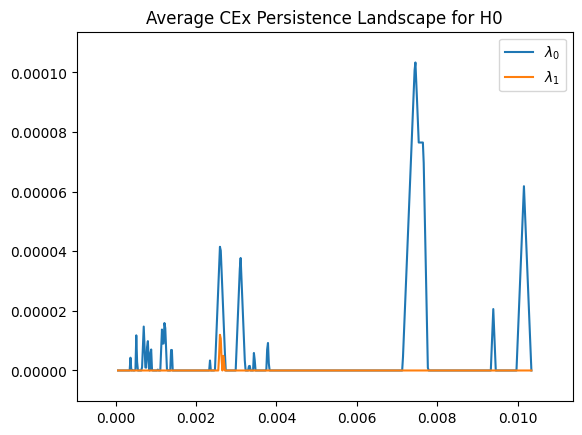

In [16]:
plot_landscape_simple(avg_v1_CEX_landscape, title = "Average CEx Persistence Landscape for H0", depth_range = range(10))

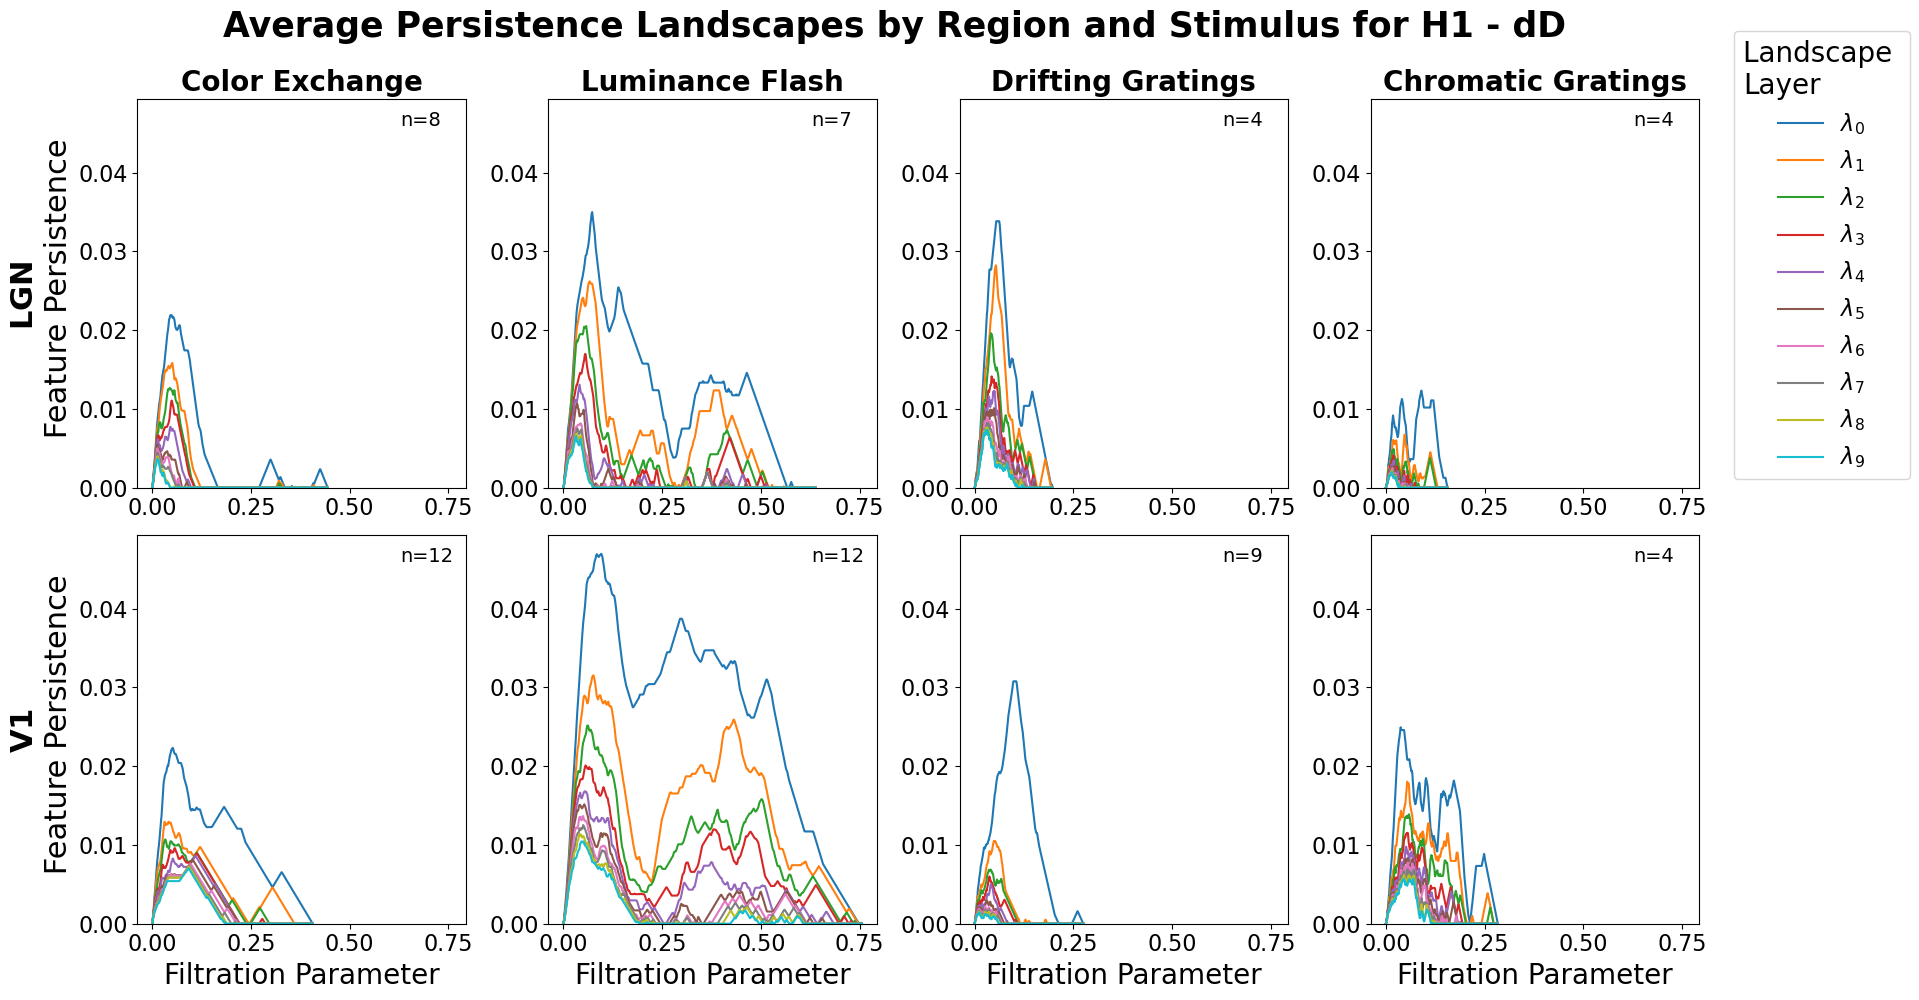

In [ ]:
# plot all landscapes for V1 and LGN for each stimulus per homology group

fig, axes = plt.subplots(2, 4, figsize=(18, 10))

#  landscapes and labels
landscapes = {
    'LGN': {
        'CEX': avg_lgn_CEX_landscape,
        'LF': avg_lgn_LF_landscape,
        'DG': avg_lgn_DG_landscape,
        'CG': avg_lgn_CG_landscape
    },
    'V1': {
        'CEX': avg_v1_CEX_landscape,
        'LF': avg_v1_LF_landscape,
        'DG': avg_v1_DG_landscape,
        'CG': avg_v1_CG_landscape
    }
}

landscape_inputs = {
    'LGN': {
        'CEX': lgn_CEX_landscape,
        'LF': lgn_LF_landscape,
        'DG': lgn_DG_landscape,
        'CG': lgn_CG_landscape
    },
    'V1': {
        'CEX': v1_CEX_landscape,
        'LF': v1_LF_landscape,
        'DG': v1_DG_landscape,
        'CG': v1_CG_landscape
    }
}

def count_diagrams_for_pl(pl, hom_deg):
    """ Counts the number of diagrams in a persistence landscape

    Args:
        pl: PersLandscapeApprox object
        hom_deg: int homology group degree
    Returns:
    diag_source = None """

    for attr in ('dgms', '_dgms', 'diagrams', '_diagrams'):
        if hasattr(pl, attr):
            diag_source = getattr(pl, attr)
            if diag_source is not None:
                break
    if diag_source is None:
        return 1
    if isinstance(diag_source, dict):
        diag_source = diag_source.get(hom_deg, diag_source)
    if isinstance(diag_source, (list, tuple)):
        if len(diag_source) == 0:
            return 0
        first = diag_source[0]
        if isinstance(first, np.ndarray):
            if first.ndim == 2 and first.shape[-1] >= 2:
                return len(diag_source)
            if first.ndim == 1 and len(first) >= 2:
                return 1
        if isinstance(first, (list, tuple)):
            if len(first) >= 2 and all(isinstance(x, (int, float, np.integer, np.floating)) for x in first[:2]):
                return 1
            return len(diag_source)
        return len(diag_source)
    return 1

def count_dgms_for_landscape_group(pl_list, hom_deg):
    """ Counts the number of diagrams in a list of persistence landscapes

    Args:
        pl_list: list of PersLandscapeApprox objects
        hom_deg: int homology group degree
    Returns:
        int number of diagrams"""

    return sum(count_diagrams_for_pl(pl, hom_deg) for pl in pl_list)

stimuli = ['CEX', 'LF', 'DG', 'CG']
regions = ['LGN', 'V1']

counts = {
    region: {
        stim: count_dgms_for_landscape_group(landscape_inputs[region][stim], hom_deg)
        for stim in stimuli
    }
    for region in regions
}

#  calculate global x and y limits across all landscapes
all_x_values = []
all_y_values = []

for region in regions:
    for stim in stimuli:
        landscape = landscapes[region][stim]
        try:
            xs = landscape.grid
        except AttributeError:
            try:
                xs = landscape.xs
            except AttributeError:
                xs = np.linspace(landscape.start, landscape.stop, landscape.num_steps)
        
        try:
            landscapes_data = landscape.landscapes
        except AttributeError:
            try:
                landscapes_data = landscape.values
            except AttributeError:
                landscapes_data = landscape.Ls
        
        all_x_values.extend(xs)
        n_layers = min(10, len(landscapes_data))
        for i in range(n_layers):
            all_y_values.extend(landscapes_data[i])

# global limits
x_min = min(all_x_values)
x_max = max(all_x_values)
y_min = min(all_y_values)
y_max = max(all_y_values)

# Add small padding
x_padding = (x_max - x_min) * 0.05
y_padding = (y_max - y_min) * 0.05
x_min -= x_padding
x_max += x_padding
y_min = max(0, y_min - y_padding)
y_max += y_padding

# Plot landscapes 
for row_idx, region in enumerate(regions):
    for col_idx, stim in enumerate(stimuli):
        ax = axes[row_idx, col_idx]
        landscape = landscapes[region][stim]
        
        plt.sca(ax)
        plot_landscape_simple(landscape, title="", depth_range=range(10))
        ax.legend().remove()
        ax.set_xlim(x_min, x_max)
        ax.set_ylim(y_min, y_max)
        ax.tick_params(axis='x', labelsize=16)
        ax.tick_params(axis='y', labelsize=16)

        ax.text(
            0.8,
            0.97,
            f"n={counts[region][stim]}",
            transform=ax.transAxes,
            fontsize=14,
            ha='left',
            va='top',
            bbox=dict(facecolor='white', alpha=0, edgecolor='none')
        )

        if row_idx == 0:
            ax.set_title(f"{stim}", fontsize=20, fontweight='bold')
        if col_idx == 0:
            ax.set_ylabel(f"$\\bf{{{region}}}$ \n Feature Persistence", fontsize=22)
        if row_idx == 1:
            ax.set_xlabel("Filtration Parameter", fontsize=20)

handles, labels = axes[0, 0].get_legend_handles_labels()
if len(handles) == 0:
    handles = [Line2D([0], [0], color=plt.cm.viridis(i/9), linewidth=1.5) for i in range(10)]
    labels = [f'λ{i}' for i in range(10)]

axes[0,0].set_title("Color Exchange", fontsize=20, fontweight='bold')
axes[0,1].set_title("Luminance Flash", fontsize=20, fontweight='bold')
axes[0,2].set_title("Drifting Gratings", fontsize=20, fontweight='bold')
axes[0,3].set_title("Chromatic Gratings", fontsize=20, fontweight='bold')
fig.legend(handles, labels, loc='center right', bbox_to_anchor=(1.07, 0.75), title='Landscape \nLayer', fontsize=16, title_fontsize=20)
fig.suptitle(f'Average Persistence Landscapes by Region and Stimulus for H{hom_deg} - {dim[0]}D', fontsize=25, fontweight='bold', y=0.995)
plt.tight_layout(rect=[0, 0, 0.96, 1])
plt.show()


In [9]:
# utils for AUC

def landscape_auc_persim_any(pl, n_layers=None, x_min=None, x_max=None, n_bins=None, return_per_layer=False):
    """
    Compute AUC for a persim PersLandscapeApprox object

    Args:
        pl: PersLandscapeApprox object
        n_layers: int number of lambda function layers to include in AUC calculation
        x_min: float minimum x value to include in AUC calculation
        x_max: float maximum x value to include in AUC calculation
        n_bins: int number of bins to use in AUC calculation
        return_per_layer: bool whether to return per-layer AUCs

    Returns:
        total_auc: float total AUC
        per_layer_auc: np.ndarray per-layer AUCs"""

    Y_native = _get_Y_from_pl(pl) 
    # normalize to (layers, points)
    if Y_native.ndim == 1:
        Y_native = Y_native[None, :]
    # guess x-grid length
    n_points = Y_native.shape[-1]
    xs_native = _get_xs_from_pl(pl, n_points_hint=n_points)

    # If orientation is (points, layers), transpose
    if Y_native.shape[0] == xs_native.size and Y_native.shape[1] != xs_native.size:
        Y_native = Y_native.T

    # option to limit number of layers included in AUC calculation
    if n_layers is not None:
        Y_native = Y_native[:n_layers, :]

    # integration window
    if x_min is None: x_min = float(xs_native.min())
    if x_max is None: x_max = float(xs_native.max())
    if x_min >= x_max:
        raise ValueError("x_min must be < x_max.")

    mask = (xs_native >= x_min) & (xs_native <= x_max)
    xs = xs_native[mask]
    Y = Y_native[:, mask]

    # optional resampling to uniform count
    if n_bins is not None and n_bins > 1:
        xs_uniform = np.linspace(x_min, x_max, int(n_bins))
        Y = np.vstack([np.interp(xs_uniform, xs, y) for y in Y])
        xs = xs_uniform

    # integrate
    Y = np.nan_to_num(Y, copy=False)
    per_layer_auc = np.trapz(Y, xs, axis=1)
    total_auc = float(per_layer_auc.sum())

    return (total_auc, per_layer_auc) if return_per_layer else (total_auc, None)
    
def _get_xs_from_pl(pl, n_points_hint):
    """ Get x-values from a PersLandscapeApprox object

    Args:
        pl: PersLandscapeApprox object
        n_points_hint: int number of points to use in x-grid
    Returns:
        np.ndarray x-values"""

    for attr in ("grid", "xs", "x_values"):
        xs = getattr(pl, attr, None)
        if xs is not None:
            return np.asarray(xs).ravel()

    # try start/stop/num_steps trio
    if all(hasattr(pl, a) for a in ("start", "stop", "num_steps")):
        return np.linspace(float(pl.start), float(pl.stop), int(pl.num_steps))

    # try x_range
    xr = getattr(pl, "x_range", None)
    if xr is not None and n_points_hint is not None:
        return np.linspace(float(xr[0]), float(xr[1]), int(n_points_hint))

    # or just make an index grid
    if n_points_hint is not None:
        return np.arange(int(n_points_hint), dtype=float)

    raise TypeError("Could not infer x-grid from PersLandscapeApprox (no grid/xs/start/stop/num_steps/x_range).")


def _get_Y_from_pl(pl):
    """ Get Y-values from a PersLandscapeApprox object

    Args:
        pl: PersLandscapeApprox object
    Returns:
        np.ndarray Y-values"""

    for attr in ("values", "landscapes", "Ls", "y_values", "_values", "_landscapes"):
        Y = getattr(pl, attr, None)
        if Y is not None:
            Y = np.asarray(Y, dtype=float)
            return Y

    # # if there is a callable that returns landscape arrays
    # for meth in ("landscapes", "to_numpy", "as_array"):
    #     f = getattr(pl, meth, None)
    #     if callable(f):
    #         Y = np.asarray(f(), dtype=float)
    #         return Y

    # # Try iterating (list of layers)
    # try:
    #     Y = np.asarray(list(pl), dtype=float)
    #     return Y
    # except Exception:
    #     pass

    # raise TypeError("Could not extract landscape values from PersLandscapeApprox (no values/landscapes/Ls).")

In [10]:
#  AUC, peak position, and layer count across embedding dimensions and stimuli
hom_deg = 1
embedding_dims = ['3d', '8d', '24d', '32d']
stim_code_map = {
    'cex': 'Color Exchange',
    'lf': 'Luminance Flash',
    'dg': 'Drifting Gratings',
    'cg': 'Chromatic Gratings'
}
regions = ['LGN', 'V1']

metrics_records = []

for dim_label in embedding_dims:
    dim_value = int(dim_label.replace('d', ''))
    for region in regions:
        for stim_code, stim_name in stim_code_map.items():
            matching_files = [
                f for f in os.listdir(data_dir)
                if f.endswith('.pkl') and dim_label in f and region in f and stim_code in f
            ]

            landscape_entries = []
            for fname in matching_files:
                fpath = os.path.join(data_dir, fname)
                dgms = load_dgms(fpath)
                if dgms is None:
                    continue
                if isinstance(dgms, np.ndarray):
                    dgms = dgms.tolist()
                if len(dgms) <= hom_deg:
                    continue
                if dgms[hom_deg] is None or len(dgms[hom_deg]) == 0:
                    continue
                try:
                    pl = PersLandscapeApprox(dgms=dgms, hom_deg=hom_deg)
                    landscape_entries.append((fname, pl))
                except Exception:
                    continue

            if not landscape_entries:
                continue

            pls = [pl for _, pl in landscape_entries]
            try:
                if len(pls) > 1:
                    aligned_pls = snap_pl(pls)
                else:
                    aligned_pls = pls
            except Exception:
                aligned_pls = pls

            for (fname, orig_pl), snapped_pl in zip(landscape_entries, aligned_pls):
                try:
                    auc_val, _ = landscape_auc_persim_any(snapped_pl)
                except Exception:
                    auc_val = np.nan

                try:
                    Y = _get_Y_from_pl(snapped_pl)
                    if Y.ndim == 1:
                        Y = Y[None, :]
                    xs = _get_xs_from_pl(snapped_pl, n_points_hint=Y.shape[-1])
                    if Y.shape[0] == xs.size and Y.shape[1] != xs.size:
                        Y = Y.T
                    Y = np.nan_to_num(Y, nan=0.0, posinf=0.0, neginf=0.0)
                    y_max_per_layer = np.max(Y, axis=1)
                    layer_count = int(np.sum(y_max_per_layer > 1e-6))
                    peak_idx = np.argmax(Y)
                    peak_pos = float(xs[np.unravel_index(peak_idx, Y.shape)[-1]])
                except Exception:
                    peak_pos = np.nan
                    layer_count = np.nan

                metrics_records.append({
                    'region': region,
                    'stimulus': stim_name,
                    'stim_code': stim_code,
                    'dimension': dim_label,
                    'dimension_numeric': dim_value,
                    'auc': auc_val,
                    'peak_position': peak_pos,
                    'layer_count': layer_count,
                    'diagram_count': count_diagrams_for_pl(orig_pl, hom_deg),
                    'file': fname
                })

topo_metrics_df = pd.DataFrame(metrics_records)

if topo_metrics_df.empty:
    print('No metrics could be computed for the selected configuration.')
else:
    summary_df = (
        topo_metrics_df
        .groupby(['region', 'stimulus', 'stim_code', 'dimension', 'dimension_numeric'], as_index=False)
        .agg(
            auc_mean=('auc', 'mean'),
            auc_std=('auc', 'std'),
            auc_count=('auc', 'count'),
            peak_position_mean=('peak_position', 'mean'),
            peak_position_std=('peak_position', 'std'),
            peak_position_count=('peak_position', 'count'),
            layer_count_mean=('layer_count', 'mean'),
            layer_count_std=('layer_count', 'std'),
            layer_count_count=('layer_count', 'count'),
            diagram_count=('diagram_count', 'sum')
        )
    )

    display(summary_df.head())

,region,stimulus,stim_code,dimension,dimension_numeric,auc_mean,auc_std,auc_count,peak_position_mean,peak_position_std,peak_position_count,layer_count_mean,layer_count_std,layer_count_count,diagram_count
0,LGN,Chromatic Gratings,cg,24d,24,0.031206,NaN,1,0.093917,NaN,1,4425.0,NaN,1,1
1,LGN,Chromatic Gratings,cg,32d,32,0.001089,NaN,1,0.040857,NaN,1,1745.0,NaN,1,1
2,LGN,Chromatic Gratings,cg,3d,3,0.000146,NaN,1,0.018188,NaN,1,98.0,NaN,1,1
3,LGN,Chromatic Gratings,cg,8d,8,0.003389,NaN,1,0.120471,NaN,1,769.0,NaN,1,1
4,LGN,Color Exchange,cex,24d,24,0.018341,0.001721,2,0.079817,0.015221,2,713.5,86.974134,2,2


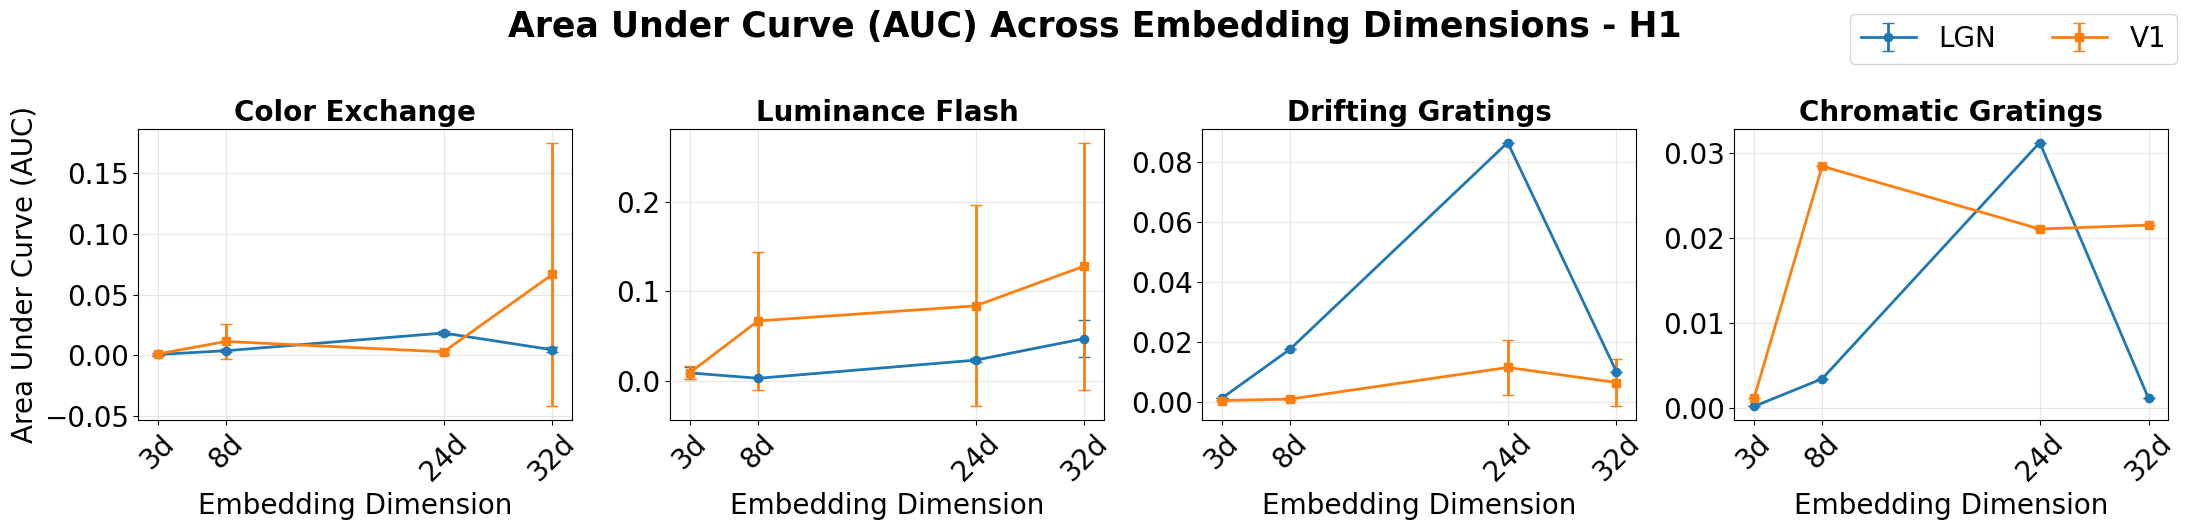

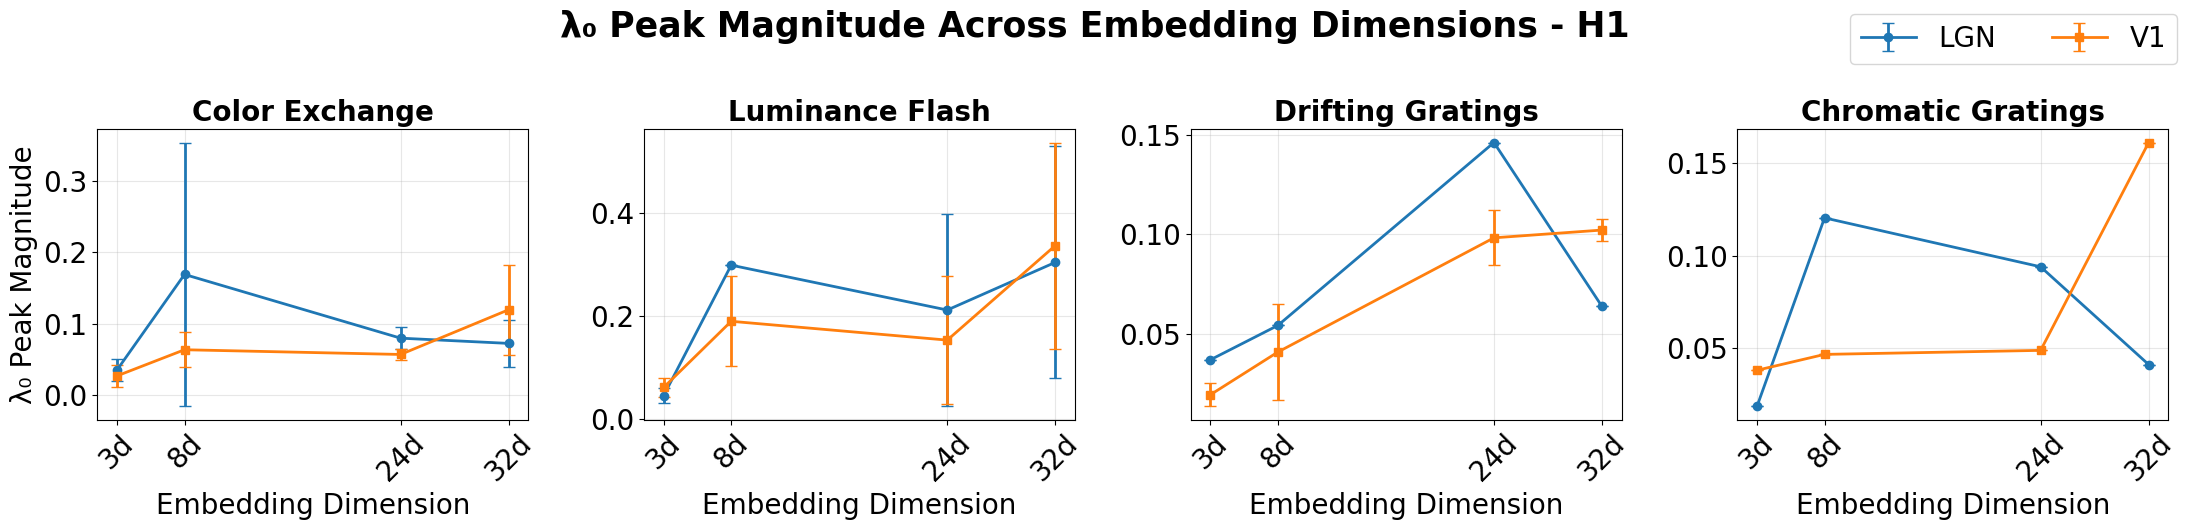

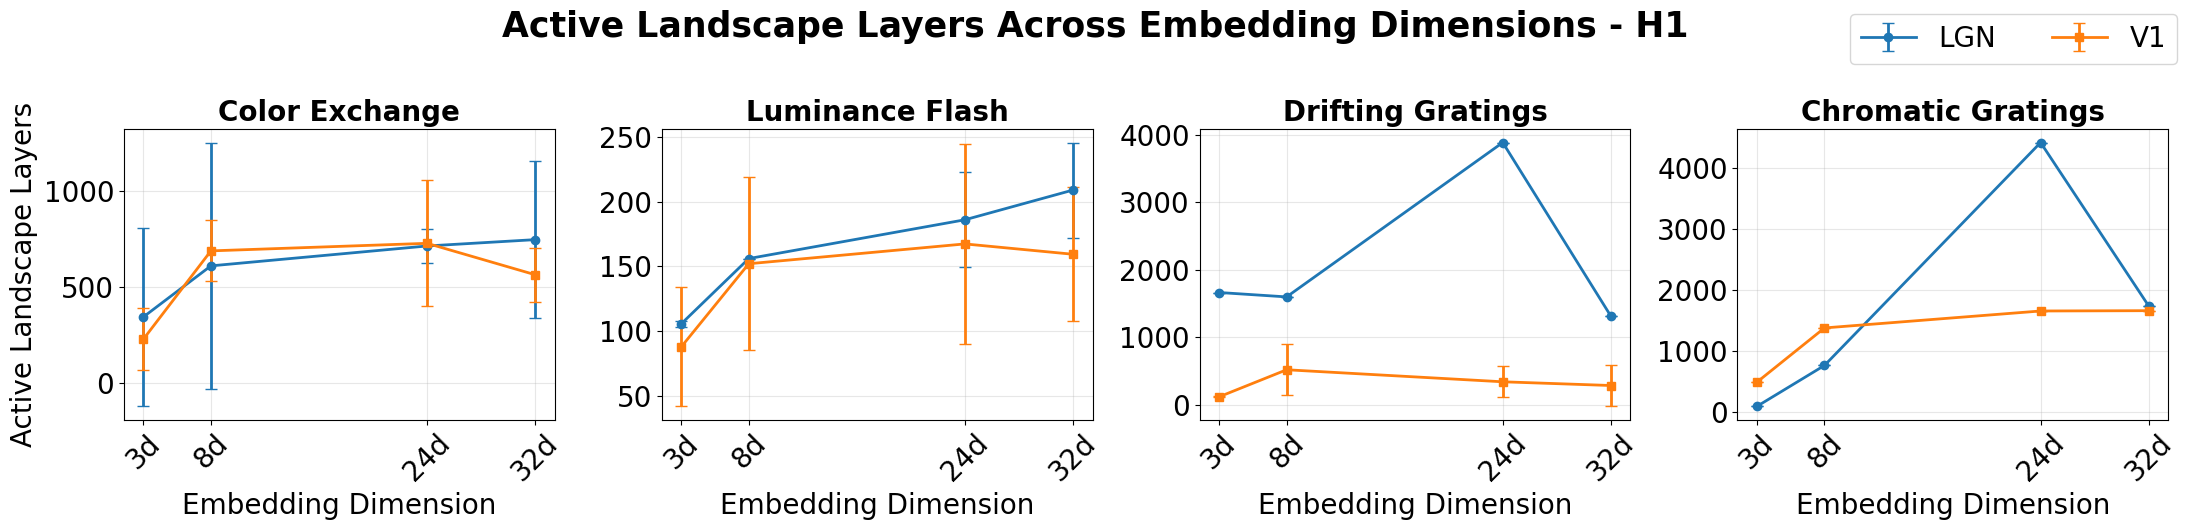

In [11]:
# plots for AUC, peak position, and layer count across embedding dimensions

if topo_metrics_df.empty or summary_df.empty:
    print('No data available for plotting metrics across embedding dimensions.')
else:
    dim_numeric_order = [int(d.replace('d', '')) for d in embedding_dims]
    dim_label_map = dict(zip(dim_numeric_order, embedding_dims))
    stim_order = ['Color Exchange', 'Luminance Flash', 'Drifting Gratings', 'Chromatic Gratings']
    region_styles = {
        'LGN': {'color': 'tab:blue', 'marker': 'o'},
        'V1': {'color': 'tab:orange', 'marker': 's'}
    }

    metric_specs = [
        ('auc', 'Area Under Curve (AUC)'),
        ('peak_position', 'λ\u2080 Peak Magnitude'),
        ('layer_count', 'Active Landscape Layers')
    ]

    for metric, metric_label in metric_specs:
        mean_col = f'{metric}_mean'
        std_col = f'{metric}_std'

        fig, axes = plt.subplots(1, len(stim_order), figsize=(22, 5), sharey=False)
        if len(stim_order) == 1:
            axes = [axes]

        legend_handles = {}

        for ax, stim in zip(axes, stim_order):
            stim_data = summary_df[summary_df['stimulus'] == stim]
            for region, style in region_styles.items():
                region_data = (
                    stim_data[stim_data['region'] == region]
                    .sort_values('dimension_numeric')
                )
                if region_data.empty:
                    continue
                y = region_data[mean_col]
                yerr = region_data[std_col].fillna(0.0)
                counts = region_data['diagram_count'].fillna(0).astype(int)
                handle = ax.errorbar(
                    region_data['dimension_numeric'],
                    y,
                    yerr=yerr,
                    label=region,
                    color=style['color'],
                    marker=style['marker'],
                    linewidth=2,
                    capsize=4
                )
                legend_handles[region] = handle

                if not y.dropna().empty:
                    y_min_val = np.nanmin(y)
                    y_max_val = np.nanmax(y)
                    y_range = y_max_val - y_min_val
                    if not np.isfinite(y_range) or y_range == 0:
                        y_range = 1.0
                else:
                    y_range = 1.0

                for x_val, y_val, count_val in zip(region_data['dimension_numeric'], y, counts):
                    if not np.isfinite(y_val):
                        continue
                    # ax.text(   -> adds n per point, seemed to busy on the plot to include this
                    #     x_val,
                    #     y_val + 0.03 * y_range,
                    #     f'n={count_val}',
                    #     fontsize=12,
                    #     color=style['color'],
                    #     ha='center',
                    #     va='bottom'
                    # )

            ax.set_title(stim, fontsize=20, fontweight='bold')
            ax.set_xlabel('Embedding Dimension', fontsize=20)
            ax.grid(alpha=0.3)
            ax.tick_params(axis='x', labelsize=20)
            ax.tick_params(axis='y', labelsize=20)
            ax.set_xticks(dim_numeric_order)
            ax.set_xticklabels([dim_label_map[d] for d in dim_numeric_order], rotation=45, fontsize=20)
        axes[0].set_ylabel(metric_label, fontsize=20)

        if legend_handles:
            fig.legend(legend_handles.values(), legend_handles.keys(), loc='upper right', ncol=len(region_styles), fontsize=20, title_fontsize=20)
        fig.suptitle(f'{metric_label} Across Embedding Dimensions - H{hom_deg}', fontsize=25, y=1.05, fontweight='bold')
        plt.tight_layout()
        plt.show()


## Compare stimulus PLs

Significance: 0.01018556909922012


<Axes: title={'center': 'Difference Landscape'}>

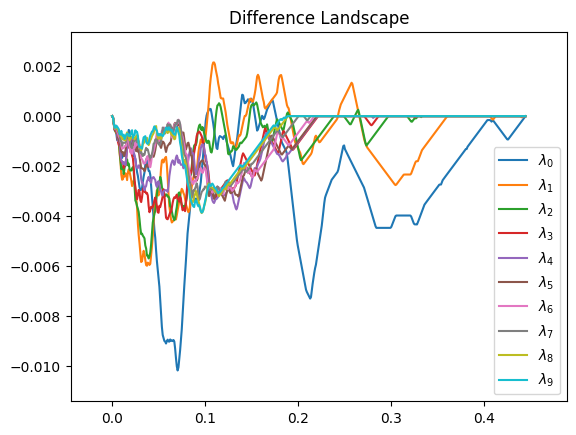

In [21]:
# CEX - CG
[avg_CEX_snapped, avg_CG_snapped] = snap_pl([avg_CEX_landscape, avg_CG_landscape])
true_diff_pl = avg_CG_snapped - avg_CEX_snapped
significance = true_diff_pl.sup_norm()

print(f"Significance: {significance}")

##plot_landscape_simple(avg_CG_landscape, title = "Average CG Persistence Landscape", depth_range = range(10))

#plot_landscape_simple(avg_CEX_landscape, title = "Average CEX Persistence Landscape", depth_range = range(10))

plot_landscape_simple(true_diff_pl, title = "Difference Landscape", depth_range=range(10))

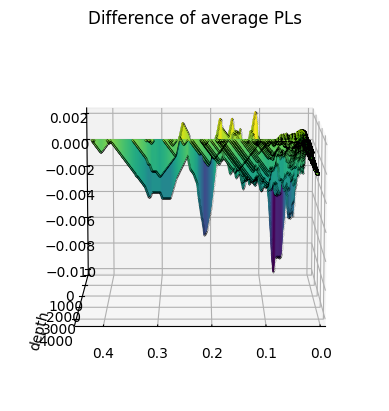

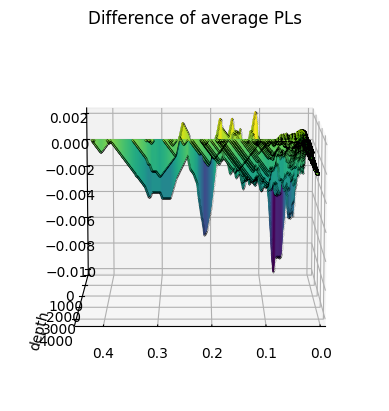

In [22]:
plot_landscape(true_diff_pl,title='Difference of average PLs')

Significance: 0.027213134892365813


<Axes: title={'center': 'Difference Landscape'}>

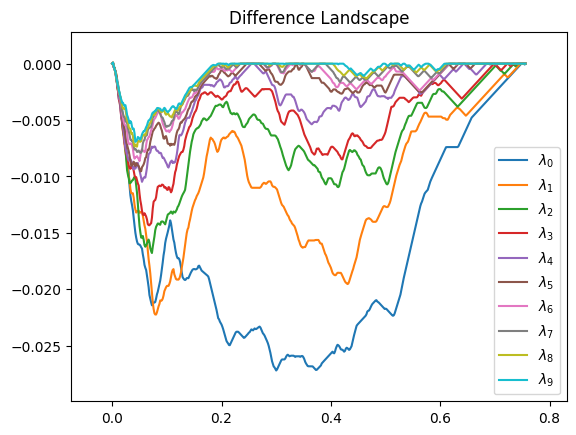

In [23]:
# LF - DG
[avg_LF_snapped, avg_DG_snapped] = snap_pl([avg_LF_landscape, avg_DG_landscape])
true_diff_pl = avg_DG_snapped - avg_LF_snapped
significance = true_diff_pl.sup_norm()

print(f"Significance: {significance}")

#plot_landscape_simple(avg_DG_landscape, title = "Average DG Persistence Landscape", depth_range = range(5))

#plot_landscape_simple(avg_LF_landscape, title = "Average LF Persistence Landscape", depth_range = range(5))

plot_landscape_simple(true_diff_pl, title = "Difference Landscape", depth_range=range(10))


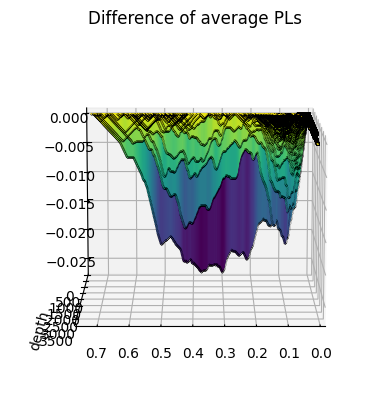

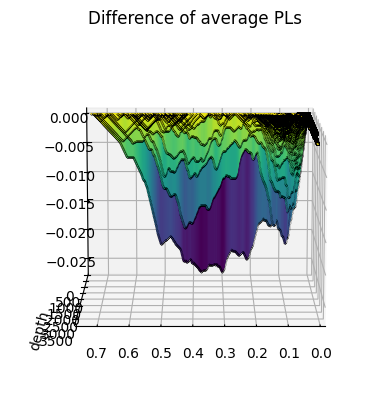

In [24]:
plot_landscape(true_diff_pl,title='Difference of average PLs')

Significance: 0.008631318305586933


<Axes: title={'center': 'Difference Landscape'}>

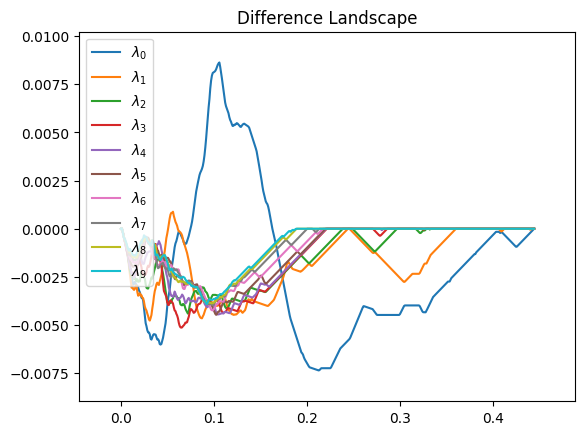

In [25]:
# CE - DG
[avg_CEX_snapped, avg_DG_snapped] = snap_pl([avg_CEX_landscape, avg_DG_landscape])
true_diff_pl = avg_DG_snapped - avg_CEX_snapped
significance = true_diff_pl.sup_norm()

print(f"Significance: {significance}")

#plot_landscape_simple(avg_DG_landscape, title = "Average DG Persistence Landscape", depth_range = range(5))

#plot_landscape_simple(avg_CEX_landscape, title = "Average CEX Persistence Landscape", depth_range = range(5))

plot_landscape_simple(true_diff_pl, title = "Difference Landscape", depth_range=range(10))


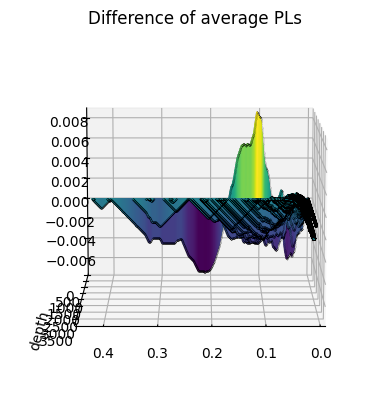

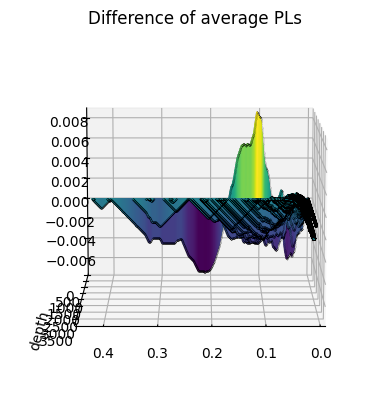

In [26]:
plot_landscape(true_diff_pl,title='Difference of average PLs')

Significance: 0.0255361087085099


<Axes: title={'center': 'Difference Landscape'}>

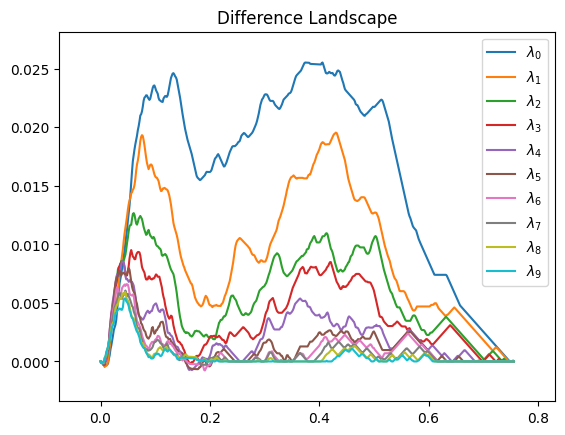

In [27]:

# CE - LF

[avg_CEX_snapped, avg_LF_snapped] = snap_pl([avg_CEX_landscape, avg_LF_landscape])
true_diff_pl = avg_LF_snapped - avg_CEX_snapped
significance = true_diff_pl.sup_norm()

print(f"Significance: {significance}")

#plot_landscape_simple(avg_LF_landscape, title = "Average LF Persistence Landscape", depth_range = range(5))

#plot_landscape_simple(avg_CEX_landscape, title = "Average CEX Persistence Landscape", depth_range = range(5))

plot_landscape_simple(true_diff_pl, title = "Difference Landscape", depth_range=range(10))

Significance: 0.030590007671896638


<Axes: title={'center': 'Difference Landscape'}>

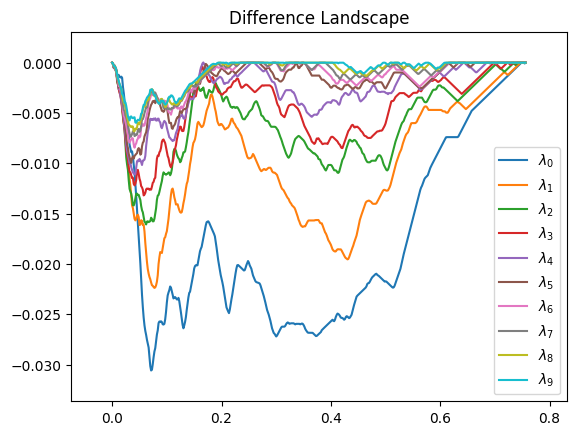

In [29]:
# LF - CG
[avg_CG_snapped, avg_LF_snapped] = snap_pl([avg_CG_landscape, avg_LF_landscape])
true_diff_pl = avg_CG_snapped - avg_LF_snapped
significance = true_diff_pl.sup_norm()

print(f"Significance: {significance}")

#plot_landscape_simple(avg_CG_landscape, title = "Average CG Persistence Landscape", depth_range = range(5))

#plot_landscape_simple(avg_LF_landscape, title = "Average LF Persistence Landscape", depth_range = range(5))

plot_landscape_simple(true_diff_pl, title = "Difference Landscape", depth_range=range(10))


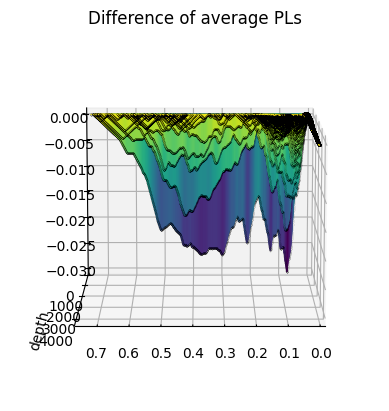

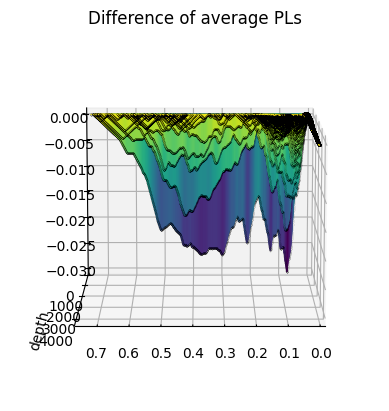

In [30]:
plot_landscape(true_diff_pl,title='Difference of average PLs')

Significance: 0.009605768966352303


<Axes: title={'center': 'Difference Landscape'}>

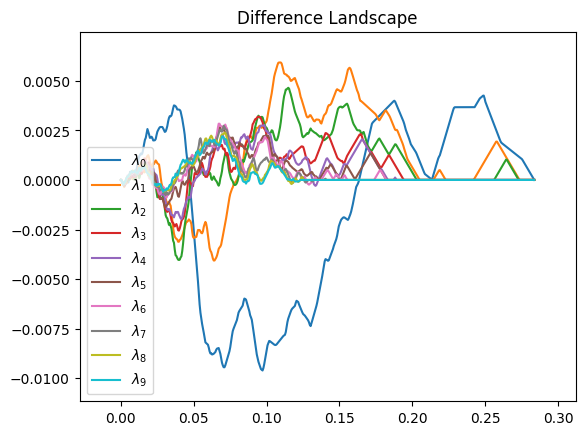

In [31]:

# DG - CG
[avg_CG_snapped, avg_DG_snapped] = snap_pl([avg_CG_landscape, avg_DG_landscape])
true_diff_pl = avg_CG_snapped - avg_DG_snapped
significance = true_diff_pl.sup_norm()

print(f"Significance: {significance}")

#plot_landscape_simple(avg_CG_landscape, title = "Average CG Persistence Landscape", depth_range = range(5))

#plot_landscape_simple(avg_DG_landscape, title = "Average DG Persistence Landscape", depth_range = range(5))

plot_landscape_simple(true_diff_pl, title = "Difference Landscape", depth_range=range(10))

## PL AUC

/var/folders/st/2v00q15s7bb4yr2r5ghl_42r0000gn/T/ipykernel_9630/875081160.py:19: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  return float(np.trapz(np.nan_to_num(lambda0, nan=0.0), xs))


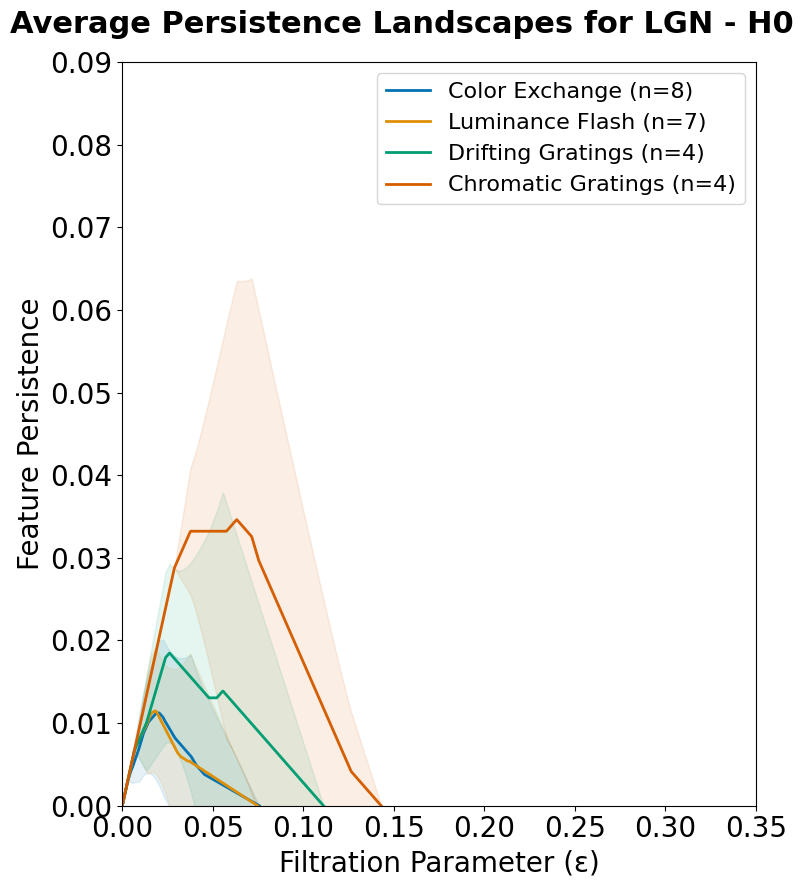

AUC table saved to: /Users/emilyekstrum/Desktop/denmanLab/tda/actual_work/v1_h0_lambda0_auc.csv


,Total Persistence (AUC)
Stimulus,
Color Exchange,0.000386
Luminance Flash,0.000381
Drifting Gratings,0.001096
Chromatic Gratings,0.002840


In [ ]:
# Plot V1 H0 lambda_0 landscape per stimulus

region = 'LGN'
hom_deg_plot = 0
stim_code_map = {
    'cex': 'Color Exchange',
    'lf': 'Luminance Flash',
    'dg': 'Drifting Gratings',
    'cg': 'Chromatic Gratings'
}
def lambda0_auc(pl):
    """ Calculate the AUC of the lambda_0 layer of a persistence landscape

    Args:
        pl: PersLandscapeApprox object
    Returns:
        float AUC of the lambda_0 layer"""

    Y = _get_Y_from_pl(pl)
    if Y.ndim == 1:
        Y = Y[None, :]
    xs = _get_xs_from_pl(pl, n_points_hint=Y.shape[-1])
    if Y.shape[0] == xs.size and Y.shape[1] != xs.size:
        Y = Y.T
    lambda0 = Y[0]
    return float(np.trapz(np.nan_to_num(lambda0, nan=0.0), xs))

v1_files_by_stim = {
    stim_name: [
        f for f in os.listdir(data_dir)
        if f.endswith('.pkl') and region in f and stim_code in f and 'd' in f]
    for stim_code, stim_name in stim_code_map.items()
}

def collect_landscapes(file_list, hom_deg):
    """  Collect persistence landscapes from a list of files

    Args:
        file_list: list of file names
        hom_deg: int homology group degree

    Returns:
        avg_pl: PersLandscapeApprox object average persistence landscape
        aligned_pls: list of PersLandscapeApprox objects aligned persistence landscapes
        count: int number of valid persistence landscapes"""

    pls = []
    count = 0
    for fname in file_list:
        fpath = os.path.join(data_dir, fname)
        dgms = load_dgms(fpath)
        if dgms is None:
            continue
        if isinstance(dgms, np.ndarray):
            dgms = dgms.tolist()
        if len(dgms) <= hom_deg:
            continue
        dgm = dgms[hom_deg]
        if dgm is None or len(dgm) == 0:
            continue
        try:
            pl = PersLandscapeApprox(dgms=dgms, hom_deg=hom_deg)
        except Exception:
            continue
        pls.append(pl)
        count += 1
    if not pls:
        return None, None, 0
    try:
        avg_pl = average_approx(pls)
        aligned_pls = snap_pl(pls) if len(pls) > 1 else pls
    except Exception:
        return None, None, count
    return avg_pl, aligned_pls, count

avg_v1_h0_by_stim = {}
all_pls_by_stim = {}
counts_v1_h0 = {}
auc_v1_h0 = {}
for stim_code, stim_name in stim_code_map.items():
    avg_pl, aligned_pls, count = collect_landscapes(v1_files_by_stim[stim_name], hom_deg_plot)
    avg_v1_h0_by_stim[stim_name] = avg_pl
    all_pls_by_stim[stim_name] = aligned_pls
    counts_v1_h0[stim_name] = count
    auc_v1_h0[stim_name] = lambda0_auc(avg_pl) if avg_pl is not None else np.nan

stim_order = ['Color Exchange', 'Luminance Flash', 'Drifting Gratings', 'Chromatic Gratings']
color_palette = sns.color_palette('colorblind', len(stim_order))
fig, ax = plt.subplots(figsize=(8, 9))

for color, stim_name in zip(color_palette, stim_order):
    avg_pl = avg_v1_h0_by_stim.get(stim_name)
    aligned_pls = all_pls_by_stim.get(stim_name, [])
    count = counts_v1_h0.get(stim_name, 0)
    if avg_pl is None:
        continue
    
    Y = _get_Y_from_pl(avg_pl)
    if Y.ndim == 1:
        Y = Y[None, :]
    xs = _get_xs_from_pl(avg_pl, n_points_hint=Y.shape[-1])
    if Y.shape[0] == xs.size and Y.shape[1] != xs.size:
        Y = Y.T
    lambda0_mean = Y[0]
    
    if aligned_pls and len(aligned_pls) > 1:
        lambda0_all = []
        for pl in aligned_pls:
            Y_pl = _get_Y_from_pl(pl)
            if Y_pl.ndim == 1:
                Y_pl = Y_pl[None, :]
            xs_pl = _get_xs_from_pl(pl, n_points_hint=Y_pl.shape[-1])
            if Y_pl.shape[0] == xs_pl.size and Y_pl.shape[1] != xs_pl.size:
                Y_pl = Y_pl.T
            lambda0_pl = Y_pl[0]
            if len(lambda0_pl) == len(xs):
                lambda0_all.append(lambda0_pl)
            else:
                lambda0_interp = np.interp(xs, xs_pl, lambda0_pl)
                lambda0_all.append(lambda0_interp)
        
        if lambda0_all:
            lambda0_all = np.array(lambda0_all)
            lambda0_std = np.std(lambda0_all, axis=0)
            ax.fill_between(xs, lambda0_mean - lambda0_std, lambda0_mean + lambda0_std, 
                           alpha=0.1, color=color)
    
    ax.plot(xs, lambda0_mean, linewidth=2, color=color, label=f"{stim_name} (n={count})")

ax.set_xlabel('Filtration Parameter (ε)', fontsize=20)
ax.set_ylim(0, 0.09)
ax.set_xlim(0, 0.35)
ax.set_ylabel('Feature Persistence', fontsize=20)
ax.tick_params(axis='both', labelsize=20)
ax.legend(fontsize=16)
fig.suptitle(f'Average Persistence Landscapes for {region} - H{hom_deg_plot}', fontsize=22, fontweight='bold', y=0.98)
plt.tight_layout()
plt.show()

auc_table = pd.DataFrame({
    'Stimulus': stim_order,
    #'n_diagrams': [counts_v1_h0[s] for s in stim_order],
    'Total Persistence (AUC)': [np.round(auc_v1_h0[s], 6) for s in stim_order]
}).set_index('Stimulus')


display(auc_table)

## PCA on 32D CEBRA embedding -> checks if topological feature collapse is due purely to dimensionality reduction 

In [ ]:
def fit_pca_on_32d(embedding_32d, n_components=32):
    """
    Fit PCA on the full 32D CEBRA embedding.

    Args:
        embedding_32d : CEBRA embedding.

    Returns: pca object"""

    pca = PCA(n_components=n_components, svd_solver="full")
    pca.fit(embedding_32d)
    return pca


def project_embedding(pca, embedding_32d, target_dim):
    """
    Project a 32D embedding into target_dim principal components.

    Args:
        pca : fitted on the 32D embedding.
        embedding_32d (n_samples, 32)
        target_dim : number of PCs to keep

    Returns:
        X_proj (n_samples, target_dim)"""

    PCA = pca.transform(embedding_32d)  # (n_samples, 32)
    return PCA[:, :target_dim]

def compute_diagram_from_knn(embedding, maxdim=2, k=300,metric="cosine"):
    """
    Compute persistence diagrams using a KNN sparse distance matrix.

    Args:
        embedding : ndarray, shape (n_samples, d)
        maxdim : int maximum homology dimension.
        k : int number of neighbors for KNN graph.
        metric : str distance metric for KNN (e.g., 'cosine', 'euclidean').

    Returns:
        dgms : list of ndarrays
            Ripser-style diagrams: dgms[0] = H0, dgms[1] = H1, ..."""
    
    embedding = np.asarray(embedding)
    n = embedding.shape[0]

    # KNN distances
    nn = NearestNeighbors(n_neighbors=k, metric=metric)
    nn.fit(embedding)
    dists, inds = nn.kneighbors(embedding)      # shapes (n, k)

    # build symmetric sparse distance matrix (coo)
    rows = np.repeat(np.arange(n), k)
    cols = inds.ravel()
    vals = dists.ravel()

    # keep only finite/positive distances
    mask = np.isfinite(vals) & (vals > 0)
    rows = rows[mask]
    cols = cols[mask]
    vals = vals[mask]

    D_sparse = coo_matrix((vals, (rows, cols)), shape=(n, n))

    # make symmetric: D = D + D^T - min(D, D^T)
    D_sparse = D_sparse.minimum(D_sparse.T)  # ensure symmetry (min)

    # ripser on sparse distance matrix
    out = ripser(D_sparse, maxdim=maxdim, distance_matrix=True)
    return out["dgms"]



def total_persistence(dgm, min_persistence=0.0):
    """
    Sum of bar lengths in a single dgms diagram

    Args:
        dgm : ndarray, shape (n_intervals, 2)
        min_persistence : float
        Only include bars with (death - birth) >= min_persistence.

    Returns:
        float"""

    if dgm.size == 0:
        return 0.0
    lengths = dgm[:, 1] - dgm[:, 0]
    if min_persistence > 0:
        lengths = lengths[lengths >= min_persistence]
    return float(np.sum(lengths))


def count_intervals(dgm, min_persistence=0.0):
    """
    Count intervals in a single diagram satisfying a min length.

    Args:
        dgm : ndarray, shape (n_intervals, 2)
        min_persistence : float

    Returns:
        int"""

    if dgm.size == 0:
        return 0
    lengths = dgm[:, 1] - dgm[:, 0]
    if min_persistence > 0:
        return int(np.sum(lengths >= min_persistence))
    else:
        return int(len(lengths))

def analyze_single_embedding(
    embedding_32d,
    mouse_id,
    region=None,
    stim=None,
    target_dims=(3, 8, 24, 32),
    maxdim=2,
    metric="cosine",
    min_pers_long_H1=0.01,
    k=300,
):
    """
    For one 32D embedding, do:
        - PCA
        - project to target_dims
        - compute diagrams
        - summarize H0/H1
        - compute Wasserstein distance to 32D reference for H1

    Returns:
        rows : list of dict - One dict per (target_dim, homology_dim) with summary stats."""

    embedding_32d = np.asarray(embedding_32d)
    assert embedding_32d.shape[1] == 32, "Expected embedding with 32D features."

    # Fit PCA and get projections
    pca = fit_pca_on_32d(embedding_32d, n_components=32)

    projections = {}
    for d in target_dims:
        diagrams_by_dim[d] = compute_diagram_from_knn(
            projections[d],
            maxdim=maxdim,
            k=k,
            metric=metric,
        )

    # Compute diagrams for each projection
    diagrams_by_dim = {}
    for d in target_dims:
        diagrams_by_dim[d] = compute_diagram_from_knn(
            projections[d], maxdim=maxdim, metric=metric
        )

    # 32D H1 diagram for Wasserstein distances
    ref_H1 = diagrams_by_dim[32][1] if maxdim >= 1 else None

    rows = []
    for d in target_dims:
        dgms = diagrams_by_dim[d]

        for h in range(min(maxdim + 1, len(dgms))):
            dgm_h = dgms[h]

            # can choose different thresholds for H0 vs H1
            if h == 0:
                tp = total_persistence(dgm_h, min_persistence=0.0)
                n_all = count_intervals(dgm_h, min_persistence=0.0)
                n_long = count_intervals(dgm_h, min_persistence=min_pers_long_H1)
            else:
                tp = total_persistence(dgm_h, min_persistence=0.0)
                n_all = count_intervals(dgm_h, min_persistence=0.0)
                n_long = count_intervals(dgm_h, min_persistence=min_pers_long_H1)

            # Wasserstein distance to 32D only for H1
            if h == 1 and ref_H1 is not None:
                wdist_ref = wasserstein(ref_H1, dgm_h)
            else:
                wdist_ref = np.nan

            rows.append(
                {
                    "mouse": mouse_id,
                    "region": region,
                    "stim": stim,
                    "embed_dim_proj": d,
                    "homology_dim": h,
                    "total_persistence": tp,
                    "n_intervals": n_all,
                    "n_long_intervals": n_long,
                    "wass_to_32D_H1": wdist_ref,
                }
            )

    return rows

def run_dimensionality_analysis(
    single_session,
    recordings,
    target_dims=(3, 8, 24, 32),
    maxdim=2,
    k=300,
    metric="cosine",
    min_pers_long_H1=0.01,
    default_region=None,
    default_stim=None,
):
    """
    Loop over all mice in `recordings`, do the PCA+TDA analysis,
    and return a tidy pandas DataFrame.

    Assumes:
        single_session[mouse]['embedding'] -> (N, 32)

    You can optionally store region/stim in single_session[mouse],
    or just pass a default (e.g., 'LGN', 'color_exchange').
    """

    all_rows = []

    for mouse in recordings:
        if mouse not in single_session:
            print(f"[WARN] Mouse {mouse} not in single_session, skipping.")
            continue

        embedding_32d = single_session[mouse]["embedding"]

        region = single_session[mouse].get("region", default_region)
        stim = single_session[mouse].get("stim", default_stim)

        rows = analyze_single_embedding(
            embedding_32d=embedding_32d,
            mouse_id=mouse,
            region=region,
            stim=stim,
            target_dims=target_dims,
            maxdim=maxdim,
            metric=metric,
            min_pers_long_H1=min_pers_long_H1,
            k=k,
        )
        all_rows.extend(rows)

    df = pd.DataFrame(all_rows)
    return df


In [ ]:
# if __name__ == "__main__":
#     single_session = pd.read_pickle(r"/Users/emilyekstrum/Desktop/denmanLab/tda/actual_work/CEBRA_embeds/32d/LGN_32d_CEBRA_unsup_time_chromatic_gratings.pkl")
#     recordings = ['C159']

#     df = run_dimensionality_analysis(
#         single_session=single_session,
#         recordings=recordings,
#         target_dims=(3, 8, 24, 32),
#         maxdim=2,
#         metric="cosine",
#         min_pers_long_H1=0.01,
#         default_region="LGN",           
#         default_stim="chromatic_gratings",  
#     )
    
#     print(df.head())

RuntimeError: Attempting to deserialize object on a CUDA device but torch.cuda.is_available() is False. If you are running on a CPU-only machine, please use torch.load with map_location=torch.device('cpu') to map your storages to the CPU.